In [1]:
import quandl

QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'  # Your own Quandl key here
quandl.ApiConfig.api_key = QUANDL_API_KEY

SYMBOLS = [
    'AAPL','MMM', 'AXP', 'BA', 'CAT',
    'CVX', 'CSCO', 'KO', 'DD', 'XOM',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ',
    'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'UNH', 'UTX', 'TRV', 
    'VZ', 'V', 'WMT', 'WBA', 'DIS',
]

wiki_symbols = ['WIKI/%s'%symbol for symbol in SYMBOLS]
df_components = quandl.get(
    wiki_symbols, 
    start_date='2017-01-01', 
    end_date='2017-12-31', 
    column_index=11)
df_components.columns = SYMBOLS  # Renaming the columns

In [2]:
filled_df_components = df_components.fillna(method='ffill')
daily_df_components = filled_df_components.resample('24h').ffill()
daily_df_components = daily_df_components.fillna(method='bfill')

In [3]:
"""
Download the all-time NDAQ dataset
"""
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'Y7POSZ82HDK3JBCQ'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df, meta_data = ts.get_daily_adjusted(symbol='NDAQ', outputsize='full')

In [4]:
import pandas as pd

# Prepare the dataframe
df_dji = pd.DataFrame(df['5. adjusted close'])
df_dji.columns = ['NDAQ']
df_dji.index = pd.to_datetime(df_dji.index)

# Trim the new dataframe and resample
djia_2017 = pd.DataFrame(df_dji.loc['2017'])
djia_2017 = djia_2017.resample('24h').ffill()

c:\Users\ayanj\Projects\FinanceWithPython\my_env\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


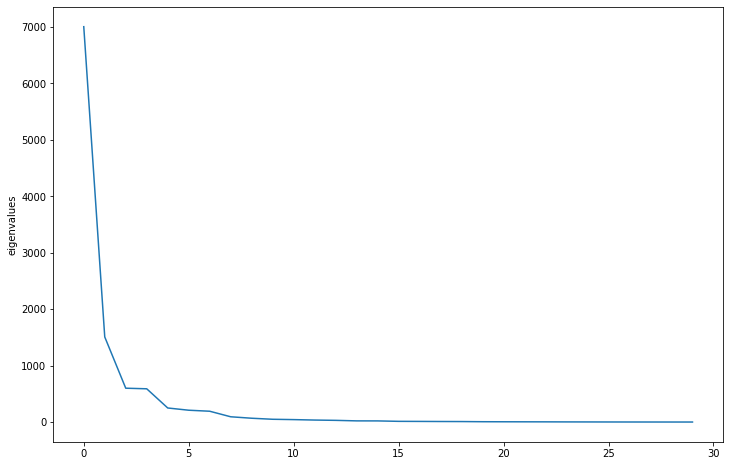

In [5]:
from sklearn.decomposition import KernelPCA

fn_z_score = lambda x: (x - x.mean()) / x.std()

df_z_components = daily_df_components.apply(fn_z_score)
fitted_pca = KernelPCA().fit(df_z_components)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,8)
plt.plot(fitted_pca.lambdas_)
plt.ylabel('eigenvalues')
plt.show();

In [6]:
fn_weighted_avg = lambda x: x / x.sum()
weighted_values = fn_weighted_avg(fitted_pca.lambdas_)[:5]

Reconstructing the Dow Index with PCA

c:\Users\ayanj\Projects\FinanceWithPython\my_env\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


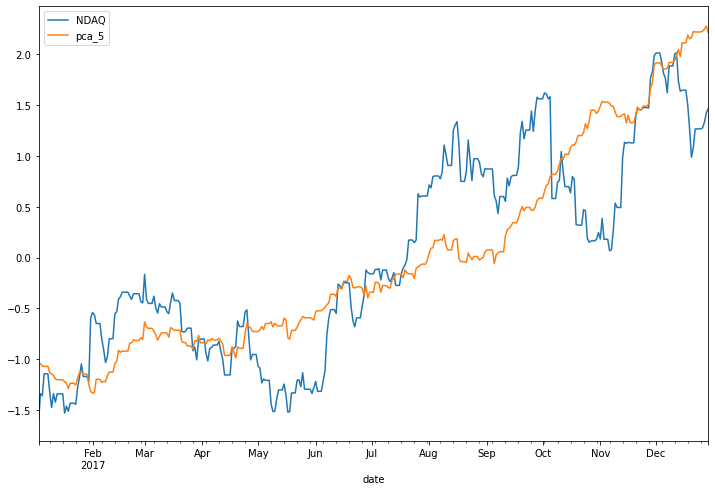

In [7]:
import numpy as np

kernel_pca = KernelPCA(n_components=5).fit(df_z_components)
pca_5 = kernel_pca.transform(df_z_components)

weights = fn_weighted_avg(kernel_pca.lambdas_)
reconstructed_values = np.dot(pca_5, weights)

# Combine DJIA and PCA index for comparison
df_combined = djia_2017.copy()
df_combined['pca_5'] = reconstructed_values
df_combined = df_combined.apply(fn_z_score)
df_combined.plot(figsize=(12, 8));

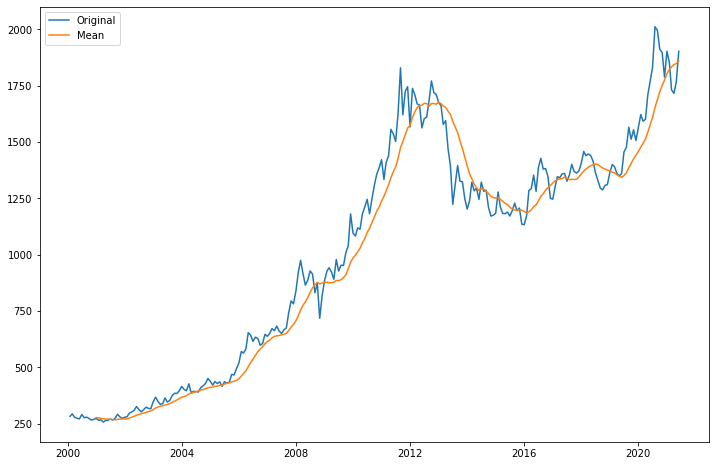

In [8]:
import quandl

QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'  # Your Quandl key here
quandl.ApiConfig.api_key = QUANDL_API_KEY

df = quandl.get(
    'CHRIS/CME_GC1', 
    column_index=6,
    collapse='monthly',
    start_date='2000-01-01')

df_settle = df['Settle'].resample('MS').ffill().dropna()

df_rolling = df_settle.rolling(12)
df_mean = df_rolling.mean()
df_std = df_rolling.std()

plt.figure(figsize=(12, 8))
plt.plot(df_settle, label='Original')
plt.plot(df_mean, label='Mean')
plt.legend();



<AxesSubplot:xlabel='Date'>

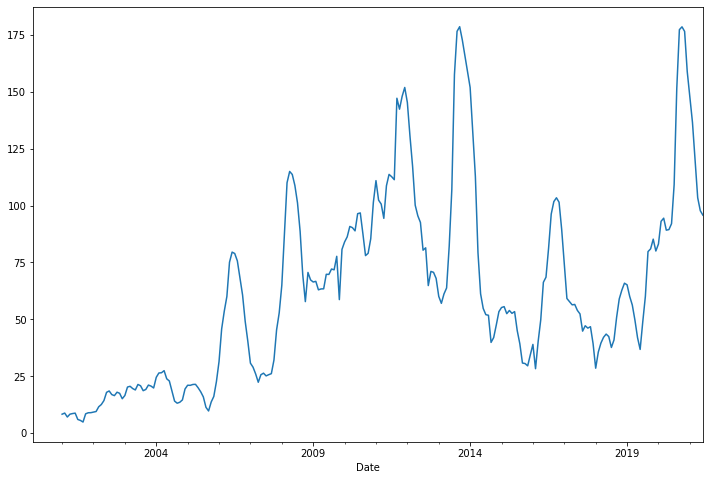

In [9]:
"""
Visualizing the rolling standard deviation 
"""
df_std.plot(figsize = (12,8))

The ADF Root unit test is a test that can determine if a time series is stationary or not, and if the p value is greater than 0.05, then we fail to reject the null hypothesis and the time series is non stationary 

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_settle)
print('ADF statistic: ',  result[0])
print('p-value:', result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -0.672745036945043
p-value: 0.8536834573174021
Critical value (1%): -3.457
Critical value (5%): -2.873
Critical value (10%): -2.573


Making a Time series stationary by removing trends or seasonality

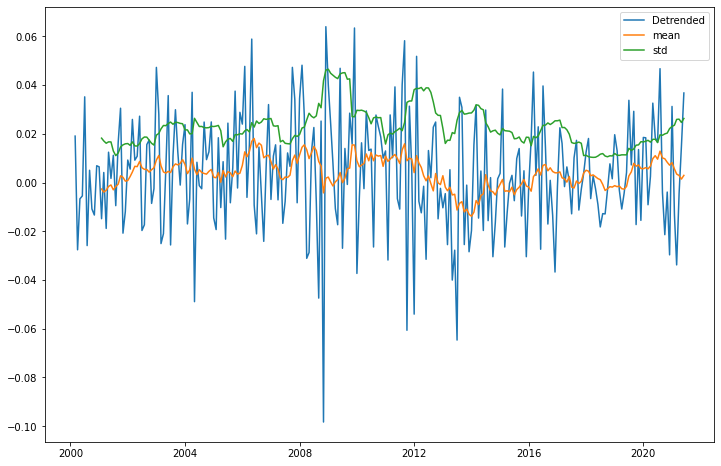

In [11]:
import numpy as np

df_log = np.log(df_settle)

df_log_ma = df_log.rolling(2).mean()
df_detrend = df_log - df_log_ma
df_detrend.dropna(inplace=True)

df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

plt.figure(figsize=(12, 8))
plt.plot(df_detrend, label='Detrended')
plt.plot(df_detrend_ma, label='mean')
plt.plot(df_detrend_std, label='std')
plt.legend(loc='upper right');

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_detrend)
print('ADF statistic: ', result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -17.836160112718897
p-value: 0.00000
Critical value (1%): -3.456
Critical value (5%): -2.873
Critical value (10%): -2.573


Removing a trend by differencing with the time log

ADF statistic: -3.400813552663459
p-value: 0.01093
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


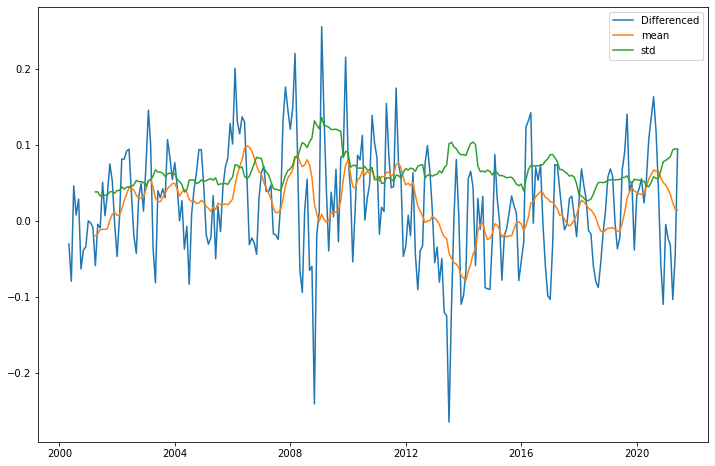

In [13]:
df_log_diff = df_log.diff(periods=3).dropna()

df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label='Differenced')
plt.plot(df_diff_ma, label='mean')
plt.plot(df_diff_std, label='std')
plt.legend(loc='upper right');

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_log_diff)

print('ADF statistic:', result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

Seasonal Decomposing by modeling both trend and seasonality, and then removing them 

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(df_log.dropna(), period=12)

df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

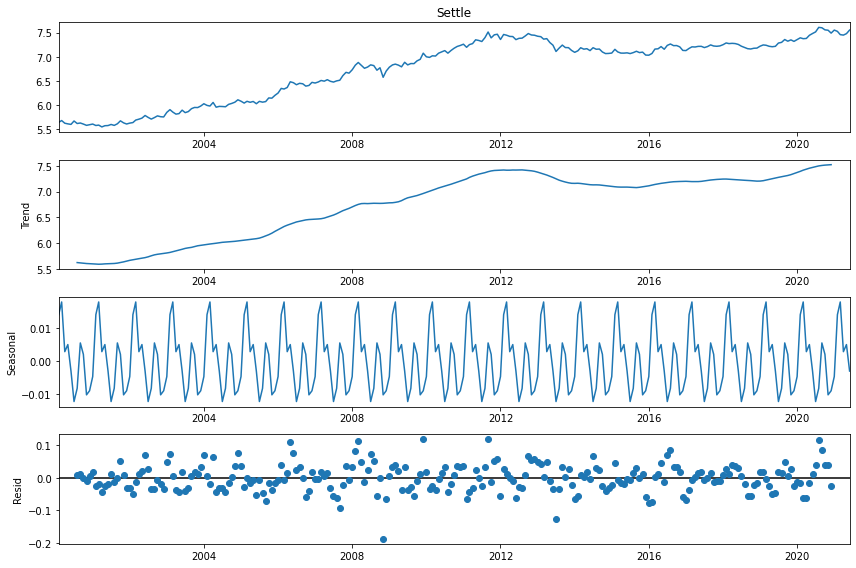

In [16]:
plt.rcParams["figure.figsize"] = (12, 8)
fig = decompose_result.plot()

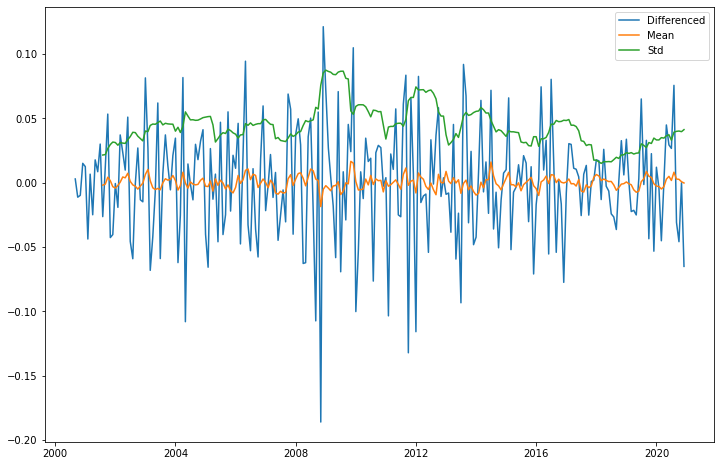

In [17]:
df_log_diff = df_residual.diff().dropna()

df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label='Differenced')
plt.plot(df_diff_ma, label='Mean')
plt.plot(df_diff_std, label='Std')
plt.legend();

In [18]:
result = adfuller(df_residual.dropna())

print('ADF statistic:',  result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic: -6.851743406274063
p-value: 0.00000
Critical value (1%): -3.459
Critical value (5%): -2.874
Critical value (10%): -2.573


As you can see with the three methods above, the p value is either zero or less than the critical value, making them stationary

FORECASTING AND PREDICTING A TIME SERIES 

We can fit a seasonal ARIMA model, which is an Autoregressing Integrated Moving Average, with the SARIMAX() function of the statsmodels module in each iteration, returning an object of the MLEResults class. This class returns an AIC value, which indicates what the better fit model is, and in our case it will take the paramters of p, d, and 1. 

In [19]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe,s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0

    for order in param_combinations:
        for(p, d, q) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations+=1
            try:
                model = SARIMAX(df_settle, order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    disp=False
                )
                model_result = model.fit(maxiter=200, disp=False)
                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order

            except Exception as ex:
                continue

    return lowest_aic, pdq, pdqs             

lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 2536.884


Fitting the SARIMAX model

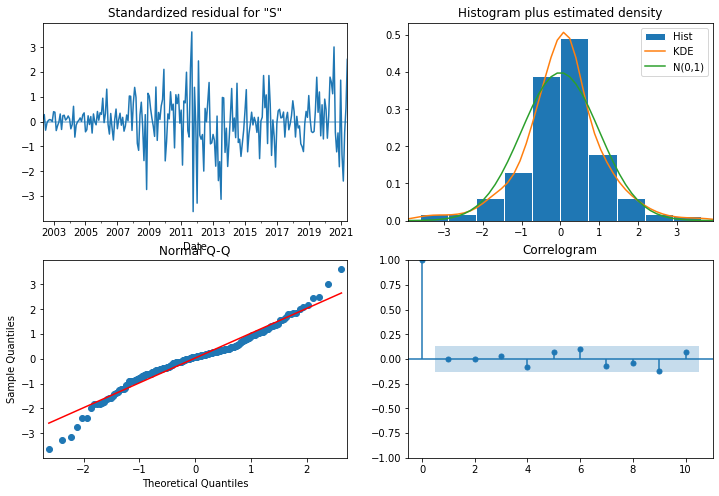

In [20]:
model = SARIgiMAX(
    df_settle,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

model_results.plot_diagnostics(figsize=(12, 8));

Predicting the Model

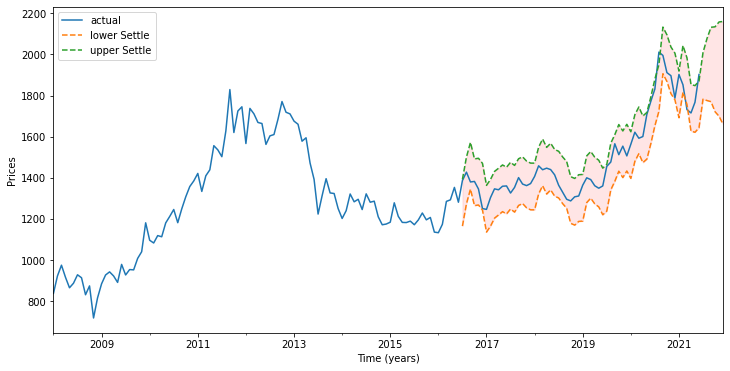

In [21]:
n = len(df_settle.index)
prediction = model_results.get_prediction(
    start=n-12*5, 
    end=n+5
)
prediction_ci = prediction.conf_int()

plt.figure(figsize=(12, 6))

ax = df_settle['2008':].plot(label='actual')
prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
    color='r', alpha=.1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()